In [ ]:
import torch
import torch.nn as nn
import math
class _Residual_Block(nn.Module):
    def __init__(self):
        super(_Residual_Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.in1 = nn.InstanceNorm2d(64, affine=True)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.in2 = nn.InstanceNorm2d(64, affine=True)

    def forward(self, x):
        identity_data = x
        output = self.relu(self.in1(self.conv1(x)))
        output = self.in2(self.conv2(output))
        output = torch.add(output,identity_data)
        return output 

class _NetG(nn.Module):
    def __init__(self):
        super(_NetG, self).__init__()

        self.conv_input = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=1, padding=4, bias=False)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        
        self.residual = self.make_layer(_Residual_Block, 16)

        self.conv_mid = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_mid = nn.InstanceNorm2d(64, affine=True)

        self.upscale4x = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv_output = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, stride=1, padding=4, bias=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        print(x.shape)
        out = self.relu(self.conv_input(x))
        residual = out
        out = self.residual(out)
        out = self.bn_mid(self.conv_mid(out))
        out = torch.add(out,residual)
        out = self.upscale4x(out)
        out = self.conv_output(out)
        return out
    
model = _NetG()
model = model.cuda()

x = torch.zeros([1,3,256,256]).cuda()
output = model(x)

print(output.shape)

In [ ]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

class _Residual_Block(nn.Module):
    def __init__(self):
        super(_Residual_Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.in1 = nn.InstanceNorm2d(64, affine=True)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.in2 = nn.InstanceNorm2d(64, affine=True)

    def forward(self, x):
        identity_data = x
        output = self.relu(self.in1(self.conv1(x)))
        output = self.in2(self.conv2(output))
        output = torch.add(output,identity_data)
        return output 

class myUpsample(nn.Module):
    def __init__(self, scale_factor, mode='bilinear', align_corners=False):
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners
    def forward(self, input):
        return F.interpolate(input, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners)

class NetARW(nn.Module):
    def __init__(self, up_ratio=2, up_type='subpixel'):
        super(NetARW, self).__init__()
        
        self.up_ratio = up_ratio
        self.conv_input = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=9, stride=1, padding=4, bias=False)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        
        self.residual = self.make_layer(_Residual_Block, 16)

        self.conv_mid = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_mid = nn.InstanceNorm2d(64, affine=True)
        if up_type == 'subpixel':
            self.upscale2x = nn.Sequential(
                nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.PixelShuffle(2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.PixelShuffle(2),
                nn.LeakyReLU(0.2, inplace=True),
            )
            self.upscale2x_1 = nn.Sequential(
                nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.PixelShuffle(2),
                nn.LeakyReLU(0.2, inplace=True),
            )
            self.upscale2x_2 = nn.Sequential(
                nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.PixelShuffle(2),
                nn.LeakyReLU(0.2, inplace=True),
            )
        if up_type == 'deconv':
            self.upscale2x = nn.Sequential(
                nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                #F.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                nn.LeakyReLU(0.2, inplace=True),
            )
            self.upscale2x_1 = nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                nn.LeakyReLU(0.2, inplace=True),
            )
            self.upscale2x_2 = nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                nn.LeakyReLU(0.2, inplace=True),
            )
        
        self.conv_output = nn.Conv2d(in_channels=256, out_channels=3, kernel_size=9, stride=1, padding=4, bias=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        print(x.shape)
        out = self.relu(self.conv_input(x))
        residual = out
        out = self.residual(out)
        out = self.bn_mid(self.conv_mid(out))
        out = torch.add(out,residual)
        out = self.upscale2x(out)
        if self.up_ratio == 4:
            out = self.upscale2x_1(out)
        
        if self.up_ratio == 8:
            out = self.upscale2x_1(out)
            out = self.upscale2x_2(out)
        
        print(out.shape)
        out = self.conv_output(out)
        return out

model = NetARW(up_type="deconv", up_ratio=2)
model = model.cuda()
x = torch.zeros([1,4,64,64]).cuda()
output = model(x)

print(output.shape)

In [ ]:
import torch
import numpy as np
a = torch.randn(1, 3, 16, 16)
#a = torch.from_numpy(np.arange(0,256)).view(1,1,16,16)
#print(a)
print(a.shape)
kernel_size = 8
kernel_stride = 8
a = a.unfold(2, kernel_size, kernel_stride)
print(a.shape)
a = a.unfold(3, kernel_size, kernel_stride)
print(a.shape)
a = a.contiguous().view(a.size(0), a.size(1), -1, a.size(4), a.size(5))
print(a.shape)
#print(a)

a.permute((0,2,3,4,1)).shape




In [ ]:
a = torch.randn(3,4,10)
b = torch.randn(3,10,4)

torch.matmul(a,b).shape

In [ ]:

h = w = 256
n = 20

print(h % n != 0)
if h % n != 0:
    print("hello world")
if h % n != 0 or w % n != 0 :
    raise ValueError("n: %d can not be division by h: %d or w: %d" %(n, h, w))

(512, 512, 3)
(512, 512, 3)


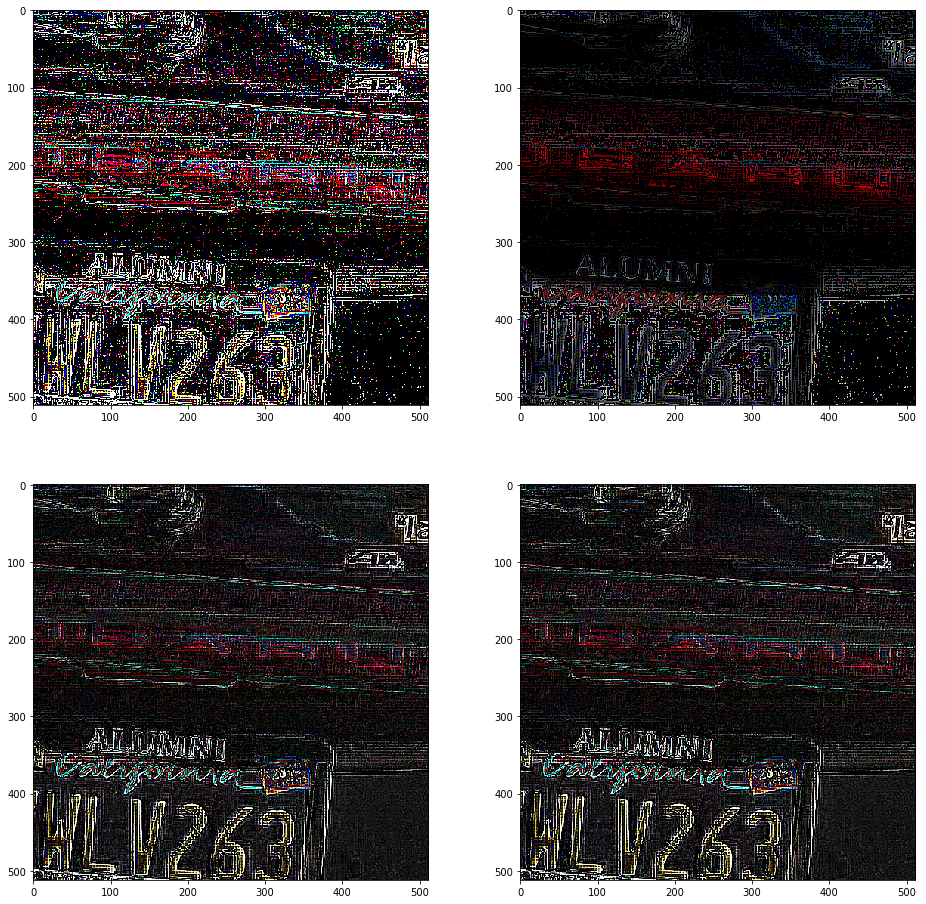

In [2]:
import os
data_root = '/store/dataset/SR/train_data/SRRAW/X4/train/'
file_name = '00579_00007.png'
diff_path = os.path.join(data_root, 'Diff', file_name)
hr_path = os.path.join(data_root, 'HR', file_name)

from PIL import Image
diff_img_o = Image.open(diff_path)
hr_img = Image.open(hr_path)

new_height = new_width = 512
width, height = diff_img_o.size   # Get dimensions

left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

diff_img_o = diff_img_o.crop((left, top, right, bottom))
hr_img = hr_img.crop((left, top, right, bottom))
#diff_img = diff_img_o.convert("L")
diff_img = diff_img_o
import numpy as np

diff_img_np = np.array(diff_img)
hr_img_np = np.array(hr_img)

diff_img_np = (diff_img_np > 50).astype(np.float32)

#diff_img_np = diff_img_np[...,np.newaxis]
#diff_img_np = np.broadcast_to(diff_img_np,(new_height,new_width,3))

print(diff_img_np.shape)
print(hr_img_np.shape)
hr_img_np = np.multiply(hr_img_np, diff_img_np).astype(np.uint8)
#print(hr_img_np)



from matplotlib import pyplot as plt
plt.figure(figsize=(16,16))



plt.subplot(221)
plt.imshow(diff_img_np, cmap='gray')

plt.subplot(222)
plt.imshow(hr_img_np)

plt.subplot(223)
plt.imshow(diff_img_o)

plt.subplot(224)
plt.imshow(diff_img_o)

plt.show()